In [1]:
!pip install -q pyyaml h5py

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [2]:
device = tf.test.gpu_device_name()
device

'/device:GPU:0'

In [4]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Changing directory to images
os.chdir("/content/drive/MyDrive/Data Analysis Bootcamp/Resources")

In [5]:
# Check Classes 
image_names=list(os.listdir("Database"))
image_names.sort()
print(image_names)
class_number = len(image_names)

['COVID19', 'NORMAL', 'Viral_Pneumonia']


In [7]:
# Directory with Atelectasis
atele_dir=os.path.join("Database/COVID19")
df =pd.DataFrame.from_records({"file_name":os.listdir(atele_dir),"condition": "Covid"})
for f in image_names[1:]:
    folder_path="Database/" + f
    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
    df=df.append(temp_df)
    
df["condition"].value_counts()

Viral_Pneumonia    1463
NORMAL             1341
Covid              1327
Name: condition, dtype: int64

In [ ]:
#Exporting Label CSV
df.to_csv("Labels.csv")

In [ ]:
# balance classes - random Random Sampling No_Finding
#df_no_finding = df[df["condition"]=="No_Finding"].sample(n=150, random_state=42)
#df_balanced = df[df["condition"]!="No_Finding"].append(df_no_finding)
#df_balanced["condition"].value_counts()

In [ ]:
#df_balanced["file_name"] = "Resources/Images/Classes/"+df_balanced["file_name"]

In [6]:
# Settings
batch_size = 128
img_height, img_width = 200,200
epochs = 50
data_dir = "Database/"

In [19]:
# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of batch_size using train_data 
train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=True, 
                seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=True, 
                seed=30)

## For evaluation
eval_train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=False, 
                seed=30)

eval_val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=False, 
                seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.
Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


Epoch 1/50
23/23 [==============================] - 1226s 54s/step - loss: 1.0789 - accuracy: 0.4434 - val_loss: 0.4834 - val_accuracy: 0.8207
Epoch 2/50
23/23 [==============================] - 78s 3s/step - loss: 0.7707 - accuracy: 0.6585 - val_loss: 0.4363 - val_accuracy: 0.8449
Epoch 3/50
23/23 [==============================] - 77s 3s/step - loss: 0.5465 - accuracy: 0.7900 - val_loss: 0.4503 - val_accuracy: 0.8086
Epoch 4/50
23/23 [==============================] - 77s 3s/step - loss: 0.4723 - accuracy: 0.8122 - val_loss: 0.2837 - val_accuracy: 0.9095
Epoch 5/50
23/23 [==============================] - 77s 3s/step - loss: 0.4080 - accuracy: 0.8419 - val_loss: 0.3144 - val_accuracy: 0.8893
Epoch 6/50
23/23 [==============================] - 75s 3s/step - loss: 0.4254 - accuracy: 0.8413 - val_loss: 0.3299 - val_accuracy: 0.8869
Epoch 7/50
23/23 [==============================] - 75s 3s/step - loss: 0.4235 - accuracy: 0.8235 - val_loss: 0.2353 - val_accuracy: 0.9144
Epoch 8/50
23/23 

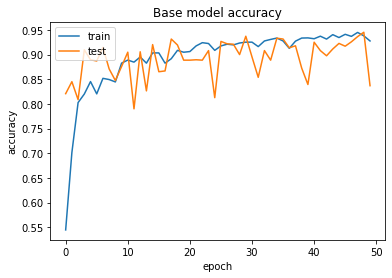

In [ ]:
# Base model

with tf.device(device):
  Base_model = tf.keras.Sequential([
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Dense(img_height, activation='relu'),
                               Flatten(),
                               Dense(class_number, activation='softmax')
                               ])
  Base_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

  Base_history = Base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  )

  plt.plot(Base_history.history['accuracy'])
  plt.plot(Base_history.history['val_accuracy'])
  plt.title('Base model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

INFO:tensorflow:Assets written to: Base_model/assets


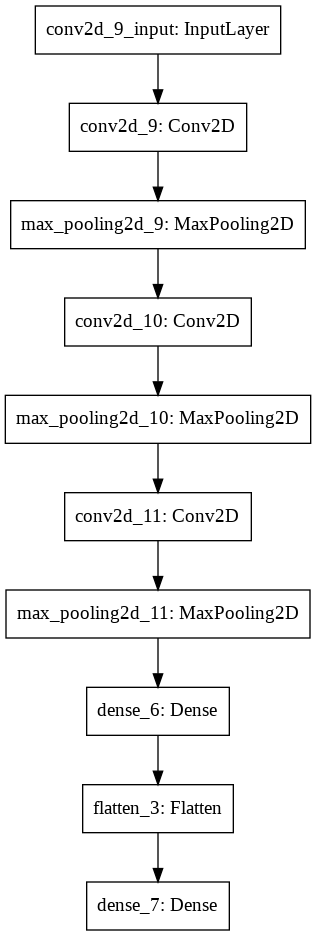

In [ ]:
Base_model.save('Base_model')

Base_hist_df = pd.DataFrame(Base_history.history) 
Base_hist_df.to_csv('Base_model/history.csv')

tf.keras.utils.plot_model(
    Base_model, to_file='Base_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)



Epoch 1/50
23/23 [==============================] - 92s 4s/step - loss: 0.8584 - accuracy: 0.6090 - val_loss: 0.4080 - val_accuracy: 0.8376
Epoch 2/50
23/23 [==============================] - 86s 4s/step - loss: 0.3644 - accuracy: 0.8671 - val_loss: 0.3435 - val_accuracy: 0.8627
Epoch 3/50
23/23 [==============================] - 86s 4s/step - loss: 0.3055 - accuracy: 0.8923 - val_loss: 0.2886 - val_accuracy: 0.8861
Epoch 4/50
23/23 [==============================] - 87s 4s/step - loss: 0.2498 - accuracy: 0.9133 - val_loss: 0.3039 - val_accuracy: 0.8853
Epoch 5/50
23/23 [==============================] - 86s 4s/step - loss: 0.2263 - accuracy: 0.9201 - val_loss: 0.2792 - val_accuracy: 0.8958
Epoch 6/50
23/23 [==============================] - 86s 4s/step - loss: 0.2093 - accuracy: 0.9290 - val_loss: 0.2908 - val_accuracy: 0.8893
Epoch 7/50
23/23 [==============================] - 85s 4s/step - loss: 0.2074 - accuracy: 0.9322 - val_loss: 0.4510 - val_accuracy: 0.8263
Epoch 8/50
23/23 [==

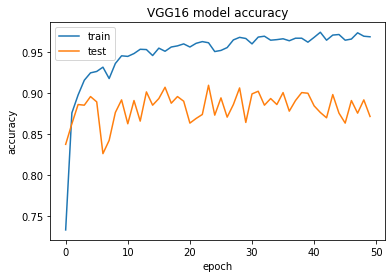

In [ ]:
# VGG16 Model

VGG16_classifier=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier.layers:
    layer.trainable=False

with tf.device(device):
  VGG16_model = tf.keras.Sequential([
                                     VGG16_classifier,
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model_history = VGG16_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1
      )
  plt.plot(VGG16_model_history.history['accuracy'])
  plt.plot(VGG16_model_history.history['val_accuracy'])
  plt.title('VGG16 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

INFO:tensorflow:Assets written to: VGG16_model/assets


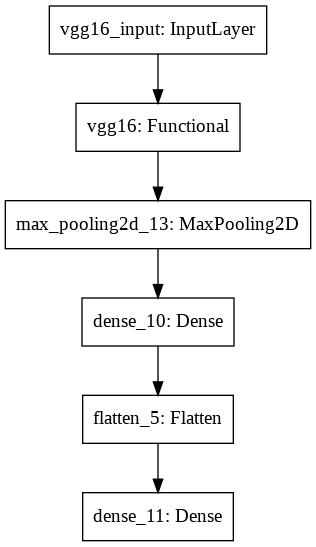

In [ ]:
VGG16_model.save('VGG16_model')

VGG16_model_history_df = pd.DataFrame(VGG16_model_history.history) 
VGG16_model_history_df.to_csv('VGG16_model/history.csv')

tf.keras.utils.plot_model(
    VGG16_model, to_file='VGG16_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
Y_pred = VGG16_model.predict_generator(val_ds2, 1238 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('VGG16_model Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(val_ds2.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("VGG16_model/confusion_matrix.csv")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(val_ds2.class_indices.keys())
print(classification_report(val_ds2.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


VGG16_model Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    351             9                     38
true: NORMAL                       0           387                     15
true: Viral_Pneumonia              3            94                    341


Classification Report
                 precision    recall  f1-score   support

        COVID19       0.99      0.88      0.93       398
         NORMAL       0.79      0.96      0.87       402
Viral_Pneumonia       0.87      0.78      0.82       438

       accuracy                           0.87      1238
      macro avg       0.88      0.87      0.87      1238
   weighted avg       0.88      0.87      0.87      1238



94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/50
23/23 [==============================] - 1182s 51s/step - loss: 1.9573 - accuracy: 0.3123 - val_loss: 0.9317 - val_accuracy: 0.6187
Epoch 2/50
23/23 [==============================] - 76s 3s/step - loss: 0.9948 - accuracy: 0.4723 - val_loss: 0.7836 - val_accuracy: 0.7617
Epoch 3/50
23/23 [==============================] - 75s 3s/step - loss: 0.8416 - accuracy: 0.6872 - val_loss: 0.6794 - val_accuracy: 0.7569
Epoch 4/50
23/23 [==============================] - 75s 3s/step - loss: 0.7761 - accuracy: 0.6657 - val_loss: 0.6492 - val_accuracy: 0.7698
Epoch 5/50
23/23 [==============================] - 75s 3s/step - loss: 0.7077 - accuracy: 0.7127 - val_loss: 0.5802 - val_accuracy: 0.7932
Epoch 6/50
23/23 [==============================] - 75s 3s/step - loss: 0.6771 - accuracy: 0.7096 - val_loss: 0.5180 - val_accuracy: 0.8005
Epoch 7/50
23/23 [==============================] - 75s 3s/step - loss: 0.6548 - accuracy: 0

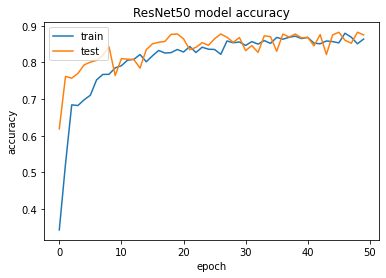

In [ ]:
#ResNet50 model

ResNet50_classifier=ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in ResNet50_classifier.layers:
    layer.trainable=False

with tf.device(device):
  ResNet50_model = tf.keras.Sequential([
                                     ResNet50_classifier,
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  ResNet50_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  ResNet50_model_history = ResNet50_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1
      )
  plt.plot(ResNet50_model_history.history['accuracy'])
  plt.plot(ResNet50_model_history.history['val_accuracy'])
  plt.title('ResNet50 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

INFO:tensorflow:Assets written to: ResNet50_model/assets


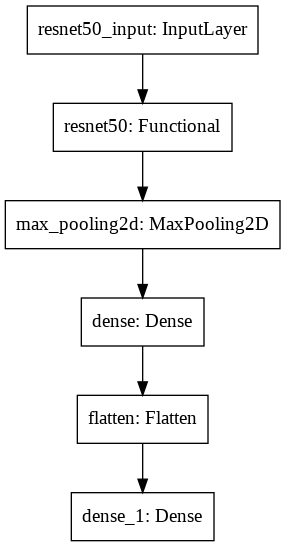

In [ ]:
ResNet50_model.save('ResNet50_model')

ResNet50_model_history_df = pd.DataFrame(ResNet50_model_history.history) 
ResNet50_model_history_df.to_csv('ResNet50_model/history.csv')

tf.keras.utils.plot_model(
    ResNet50_model, to_file='ResNet50_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
Y_pred = ResNet50_model.predict_generator(val_ds2, 1238 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('ResNet50_model Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(val_ds2.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("ResNet50_model/confusion_matrix.csv")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(val_ds2.class_indices.keys())
print(classification_report(val_ds2.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


ResNet50_model Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    369             6                     23
true: NORMAL                       4           369                     29
true: Viral_Pneumonia             12            81                    345


Classification Report
                 precision    recall  f1-score   support

        COVID19       0.96      0.93      0.94       398
         NORMAL       0.81      0.92      0.86       402
Viral_Pneumonia       0.87      0.79      0.83       438

       accuracy                           0.87      1238
      macro avg       0.88      0.88      0.88      1238
   weighted avg       0.88      0.87      0.87      1238



58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/50
23/23 [==============================] - 1165s 51s/step - loss: 1.2222 - accuracy: 0.5414 - val_loss: 0.3976 - val_accuracy: 0.8288
Epoch 2/50
23/23 [==============================] - 77s 3s/step - loss: 0.4341 - accuracy: 0.8349 - val_loss: 0.4082 - val_accuracy: 0.8304
Epoch 3/50
23/23 [==============================] - 76s 3s/step - loss: 0.3297 - accuracy: 0.8827 - val_loss: 0.3339 - val_accuracy: 0.8748
Epoch 4/50
23/23 [==============================] - 78s 3s/step - loss: 0.3075 - accuracy: 0.8947 - val_loss: 0.4062 - val_accuracy: 0.8417
Epoch 5/50
23/23 [==============================] - 78s 3s/step - loss: 0.2598 - accuracy: 0.9139 - val_loss: 0.3008 - val_accuracy: 0.8821
Epoch 6/50
23/23 [==============================] - 80s 3s/step - loss: 0.2532 - accuracy: 0.9208 - val_loss: 0.3591 - val_accuracy: 0.8546
Epoch 7/50
23/23 [==============================] - 80s 3s/step - loss: 0.2367 - accuracy: 0

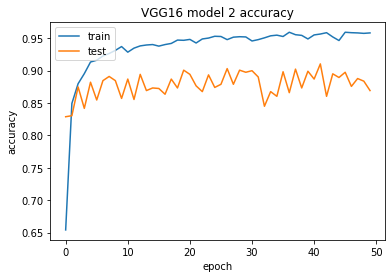

In [ ]:
# VGG16 Model with Dropout

VGG16_classifier2=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier2.layers:
    layer.trainable=False

with tf.device('/device:GPU:0'):
  VGG16_model2 = tf.keras.Sequential([
                                     VGG16_classifier2,
                                     MaxPooling2D(),
                                     Flatten(),
                                     Dense(img_height, activation='relu'),
                                     Dropout(0.5),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model2.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model2_history = VGG16_model2.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1
      )
  plt.plot(VGG16_model2_history.history['accuracy'])
  plt.plot(VGG16_model2_history.history['val_accuracy'])
  plt.title('VGG16 model 2 accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

In [ ]:
VGG16_model2_history_df = pd.DataFrame(VGG16_model2_history.history) 
VGG16_model2_history_df.to_csv('VGG16_model2.csv')

tf.keras.utils.plot_model(
    VGG16_model2, to_file='VGG16_model2.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

VGG16_model2.save('VGG16_model2.h5')

In [ ]:
val_ds

In [ ]:
labels

tf.math.confusion_matrix(
    labels, predictions, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

In [25]:
#################################################################################################################################################################################
################################################################### Load Models #################################################################################################
#################################################################################################################################################################################
model_name = 'ResNet50_model'
new_model = tf.keras.models.load_model(model_name)

In [26]:
train_loss, train_accuracy = new_model.evaluate(eval_train_ds)
print(f'\n Training loss: {train_loss}')
print(f'\n Training accuracy: {train_accuracy}')

val_loss, val_accuracy = new_model.evaluate(eval_val_ds)
print(f'\n Validation loss: {val_loss}')
print(f'\n Validation accuracy: {val_accuracy}')

23/23 [==============================] - 60s 3s/step - loss: 0.3249 - accuracy: 0.8745

 Training loss: 0.3248694837093353

 Training accuracy: 0.874524712562561
10/10 [==============================] - 18s 2s/step - loss: 0.3061 - accuracy: 0.8748

 Validation loss: 0.30606386065483093

 Validation accuracy: 0.874798059463501


In [27]:
train_Y_pred = new_model.predict(eval_train_ds, 2893 // batch_size+1, verbose=1)
train_y_pred = np.argmax(train_Y_pred, axis=1)

print(f'{model_name} Training Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(train_ds.classes, train_y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
print(conf_matrix)
print('\n')
print(f'{model_name} Training Classification Report')
target_names = list(train_ds.class_indices.keys())
print(classification_report(train_ds.classes, train_y_pred, target_names=target_names))


val_Y_pred = new_model.predict(eval_val_ds, 1238 // batch_size+1, verbose=1)
val_y_pred = np.argmax(val_Y_pred, axis=1)

print(f'{model_name} Validation Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(val_ds.classes, val_y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
print(conf_matrix)
print('\n')
print(f'{model_name} Validation Classification Report')
target_names = list(val_ds.class_indices.keys())
print(classification_report(val_ds.classes, val_y_pred, target_names=target_names))

23/23 [==============================] - 59s 3s/step
ResNet50_model Training Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    883             8                     38
true: NORMAL                      21           848                     70
true: Viral_Pneumonia            103            85                    837


ResNet50_model Training Classification Report
                 precision    recall  f1-score   support

        COVID19       0.88      0.95      0.91       929
         NORMAL       0.90      0.90      0.90       939
Viral_Pneumonia       0.89      0.82      0.85      1025

       accuracy                           0.89      2893
      macro avg       0.89      0.89      0.89      2893
   weighted avg       0.89      0.89      0.89      2893

10/10 [==============================] - 17s 2s/step
ResNet50_model Validation Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_